<a href="https://colab.research.google.com/github/KJOELJOYSON2427/Transformer_Architecture_with_Language_Translation_Pytorch/blob/new_main/TransformationModelArch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

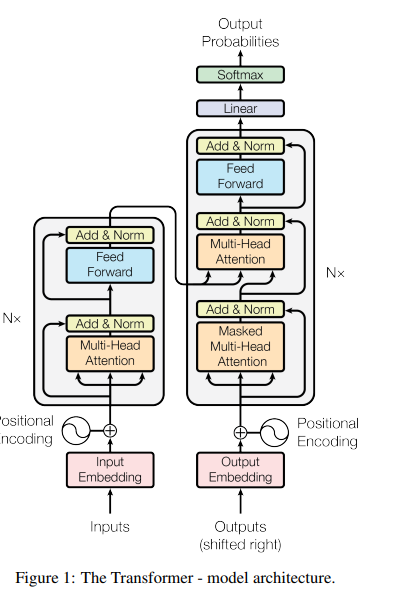

# Workflow

1.Input embedding

2.Positional Encoding

3.MultiHead Attention(self Attention)


4.Add and Norm

5.Feed Forward

6.Masked MultiHead Attention

7.Cross Attention

8.Resuidual connection

9.Encoder

10.Decoder

11.Building a transformer

12.Loading Dataset

13.Tokenization

14.Validation Loop

15.Training Loop

16.conclusion



# Import the Library

In [3]:
# This imports the torch library, a fundamental component for deep learning operations.
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import math
from torch.utils.tensorboard import SummaryWriter
#HuggingFace libraries

#Path Library
from pathlib import Path

from tqdm import tqdm
import warnings

# Input Embeddings

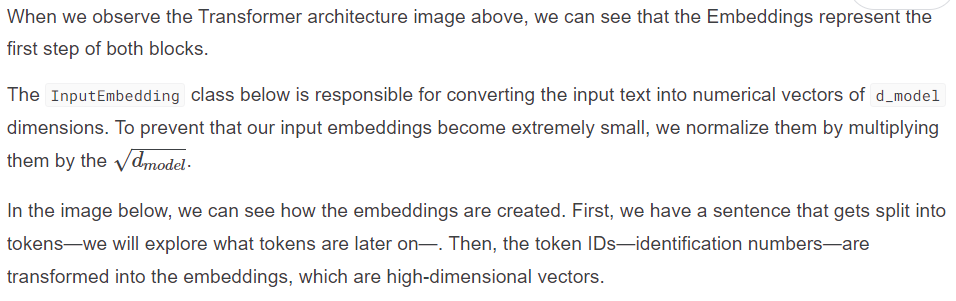

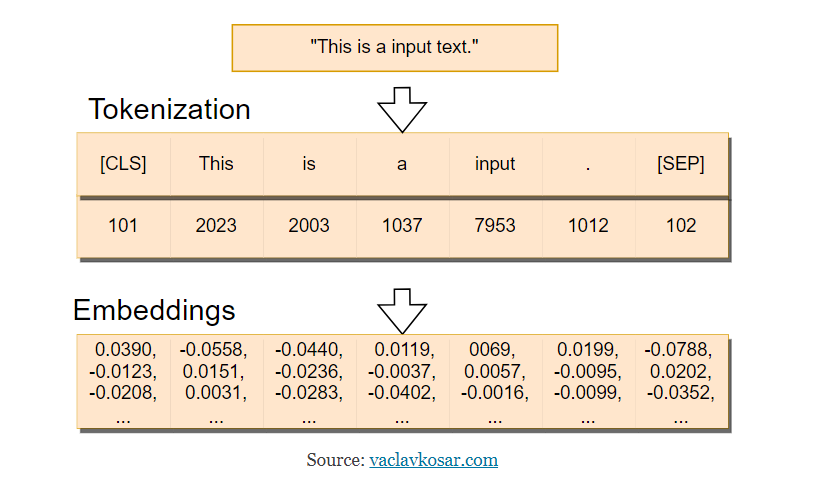

In [4]:
#create InputEmbeddings
class InputEmbeddingsLayer(nn.Module):
  def __init__(self, d_model: int, vocab_size: int):
    super().__init__()
    self.d_model = d_model # Dimension of vectors (512)
    self.vocab_size = vocab_size # Size of the vocabulary
    self.embedding= nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model) # PyTorch layer that converts integer indices to dense embedding

  def forward(self, x):
    return self.embedding(x)  * math.sqrt(self.d_model)



In [5]:
import torch

# Example positional encoding (small for demo)
seq_len = 4
d_model = 6

pe = torch.zeros(seq_len, d_model)
print("Before unsqueeze:", pe.shape)
p=torch.zeros(1)
# Adding an extra dimension: batch
pe = pe.unsqueeze(0)
print("After unsqueeze:", pe.shape)
print(p)

Before unsqueeze: torch.Size([4, 6])
After unsqueeze: torch.Size([1, 4, 6])
tensor([0.])


# Positional Encoding

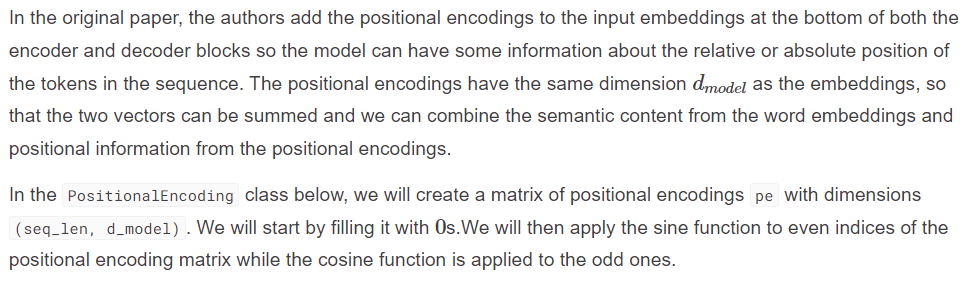

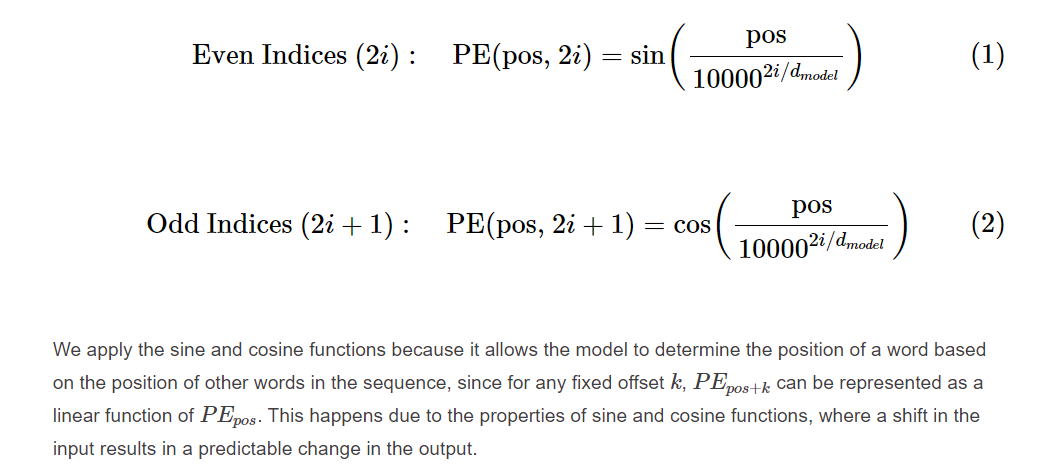

 final_input_1 = embedding(word1) + positional_vector_for_position_0
final_input_2 = embedding(word2) + positional_vector_for_position_1
final_input_3 = embedding(word3) + positional_vector_for_position_2


In [6]:
# Creating the Positional Encoding

class PositionalEncoding(nn.Module):

  def __init__(self, d_model: int, seq_len:int, dropout:float)-> None:
    super().__init__()
    self.d_model = d_model # Dimensionality of the model
    self.seq_length = seq_len # Maximum sequence length
    self.dropout = nn.Dropout(dropout)# Dropout layer to prevent overfitting

    # Creating a positional encoding matrix of shape (seq_len, d_model) filled with zeros
    pe = torch.zeros(seq_len, d_model)

    # Creating a tensor representing positions (0 to seq_len - 1)
    position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1) # Transforming 'position' into a 2D tensor['seq_len, 1']


    # Creating the division term for the positional encoding formula
    div_term = torch.exp ( torch.arange(0, d_model, 2) * (-math.log(10000)/d_model))

    # Apply sine to even indices in pe

    pe[:, 0::2] = torch.sin(position * div_term)

    pe[:, 1::2] = torch.cos(position * div_term)

    # Adding an extra dimension at the beginning of pe matrix for batch handling
    pe = pe.unsqueeze(0)

    # Registering 'pe' as buffer. Buffer is a tensor not considered as a model parameter
    self.register_buffer('pe', pe)


  def forward(self,x):
    # Adding positional encoding to the input tensor X
    x = x + (self.pe[:, :x.shape[1],:]).requires_grad_(False)
    return self.dropout(x) # Dropout for regularization



# Layer Normalization

  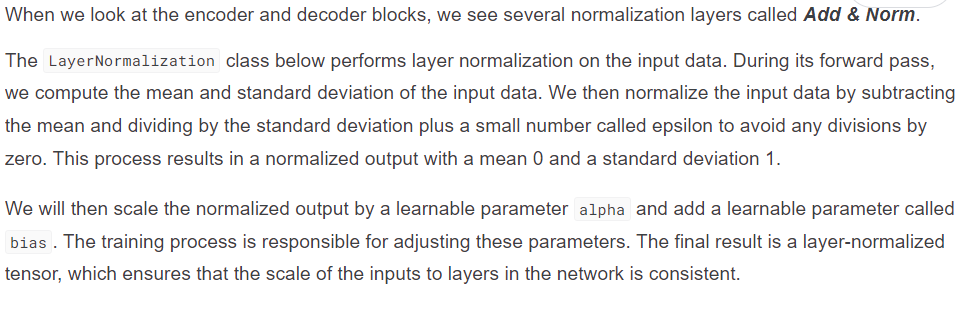

In [7]:
# Creating Layer Normalization
class LayerNormalization(nn.Module):

  def __init__(self, eps: float = 10**-6) -> None: # We define epsilon as 0.000001 to avoid division by zero
        super().__init__()
        self.eps= eps

        # We define alpha as a trainable parameter and initialize it with ones
        self.alpha = nn.Parameter(torch.ones(1))


        # We define bias as a trainable parameter and initialize it with zeros
        self.bias = nn.Parameter(torch.zeros(1)) # One-dimensional tenso that wi


  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True) # Computing the mean of the input data. Keeping the number of dimensions unchanged
    std = x.std(dim = -1, keepdim = True) # Computing the standard deviation of the input data. Keeping the number of dimensions unchanged

    # Returning the normalized input
    return self.alpha * (x-mean) /(std + self.eps) + self.bias



# Feed Foward Network

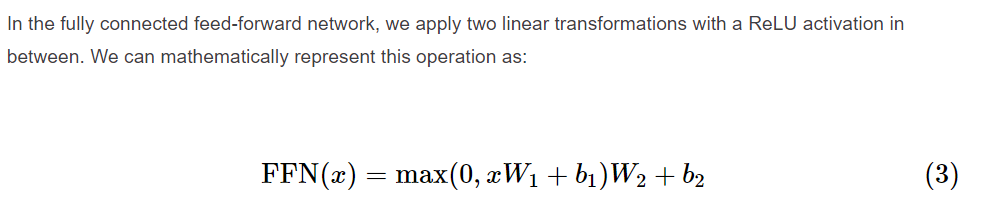

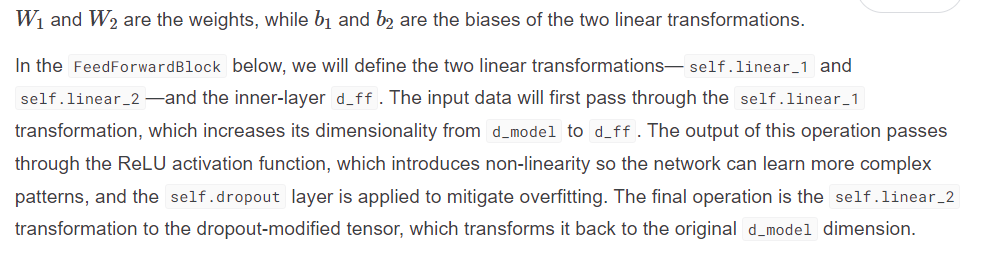

In [8]:
from torch.nn.modules import dropout
# Creating Feed Forward Layers
class FeedForwardBlock(nn.Module):

  def __init__(self, d_model: int, d_ff: int, dropout:float) -> None:
    super().__init__()
    #First linear transformation
    self.linear_1 = nn.Linear(d_model, d_ff)# W1 & b1
    self.dropout = nn.Dropout(dropout) # Dropout to prevent overfitting
    # Second linear transformation
    self.linear_2 = nn.Linear(d_ff,d_model) # W2 & b2


def forward(self, x):
  # (Batch, seq_len, d_model) --> (batch, seq_len, d_ff) -->(batch, seq_len, d_model)
  return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))





# Multihead Attention


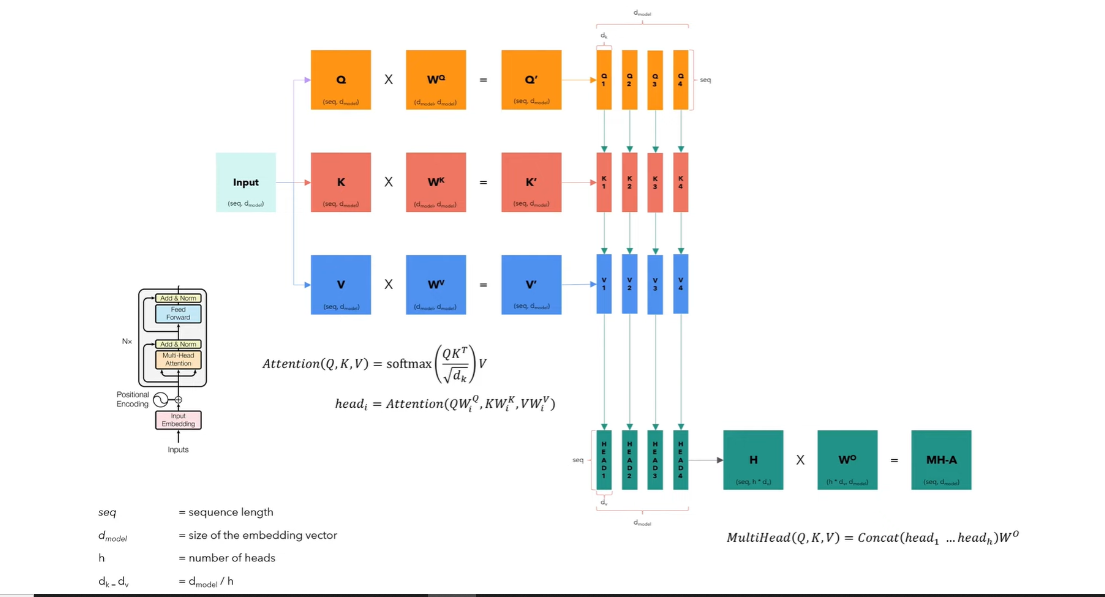

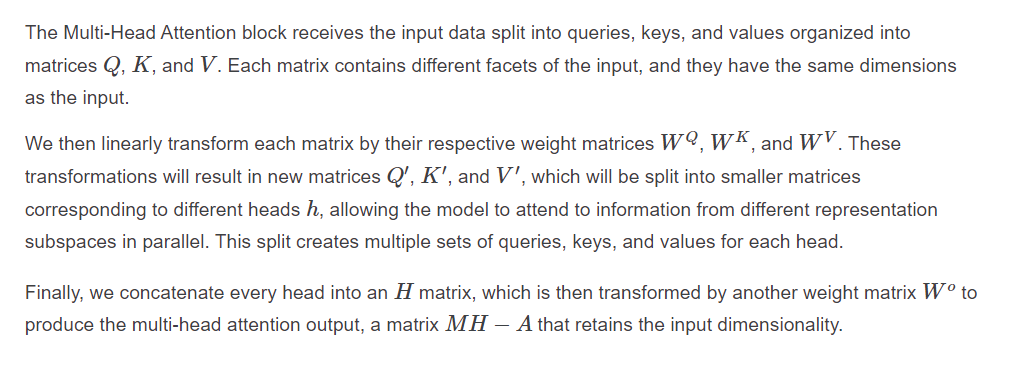

1) Make 3 copies of input → Q, K, V
2) Transform them with learnable matrices WQ, WK, WV
3) Split each into small heads
4) Each head "looks" at input differently
5) Do attention in each head
6) Join all heads back
7) Pass through one final weight WO


Types of masks
1️⃣ Padding mask

Marks padding tokens (0) so that attention ignores them

Example: [1, 1, 1, 0, 0] → last 2 tokens are padding

2️⃣ Causal / look-ahead mask

For decoder

Ensures future tokens are not seen

Upper-triangle of the mask is 0

In [9]:
# Creating the Multi-Head Attention block
class  MultiheadAttentionBlock(nn.Module):
  def __init__(self, d_model: int, h: int, dropout: float) -> None: # h = number of heads
        super().__init__()
        self.d_model = d_model
        self.h = h

        # We ensure that the dimensions of the model is divisible by the number of heads
        assert d_model % h == 0, 'd_model is not divisble by h'

        # d_k is the dimension of each attention head's key, query, and value vectors
        self.d_k = d_model // h # d_k formula, like in the original "Attention Is All You Need" paper


        # Defining the weight matrices
        self.w_q = nn.Linear(d_model, d_model) # W_q
        self.w_k = nn.Linear(d_model, d_model) # W_k
        self.w_v = nn.Linear(d_model, d_model) # W_v
        self.w_o = nn.Linear(d_model, d_model) # W_o


        self.dropout = nn.Dropout(dropout)  # Dropout layer to avoid overfitting




  # Attention(Q, K, V) = softmax( (Q Kᵀ) / sqrt(d_k) ) * V
  @staticmethod
  def attention(query, key, value, mask, dropout:nn.Dropout): #mask => When we want certain words to NOT interact with others, we "hide" them
    d_k = query.shape[-1]  # The last dimension of query, key, and value

    # We calculate the Attention(Q,K,V) as in the formula in the image above
    attention_scores =(query @ key.transpose(-2,-1))/ math.sqrt(d_k)# @ = Matrix multiplication sign in PyTorch

    # Before applying the softmax, we apply the mask to hide some interactions between words
    if mask is not None: # If a mask IS defined...
       attention_scores.masked_fill_(mask == 0, -1e9) # Replace each value where mask is equal to 0 by -1e9

    attention_scores = attention_scores.softmax(dim = -1) # Applying softmax
    if dropout is not None:
      # If a dropout IS defined...
      attention_scores = dropout(attention_scores) # We apply dropout to prevent overfitting

    return (attention_scores @ value), attention_scores # Multiply the output matrix by the V matrix, as in the formula





  def forward(self, q, k, v, mask):
    query = self.w_q(q)
    query = self.w_q(q) # Q' matrix
    key = self.w_k(k) # K' matrix
    value = self.w_v(v) # V' matrix'
    #Splitting results into smaller matrices for the different heads
    # Splitting embeddings (third dimension) into h parts
    query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
    key= key.view(key.shape[0], key.shape[1],self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension
    value= value.view(value.shape[0], value.shape[1],self.h, self.d_k).transpose(1,2) # Transpose => bring the head to the second dimension

    # Obtaining the output and the attention scores
    x, self.attention_scores = MultiheadAttentionBlock.attention(query, key, value, mask, self.dropout)

    # Obtaining the H Matrix H = concat(head1, head2, ..., head_h)
    x= x.transpose(1,2).contigous().view(x.shape[0], -1, self.h * self.d_k)

    return self.w_o(x) # Multiply the H matrix by the weight matrix W_o, resulting in the MH-A matrix



# Residual Connection

     

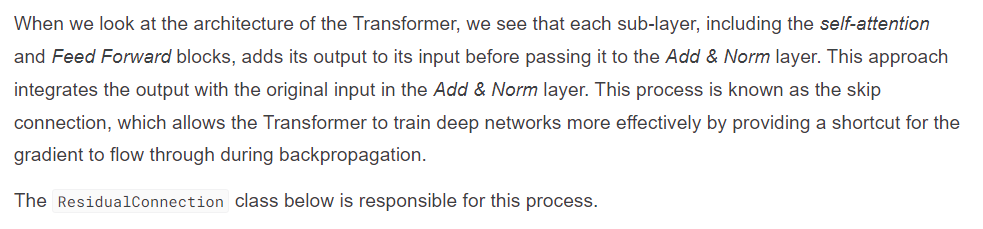

In [10]:
# Building Residual Connection
class ResidualConnection(nn.Module):
  def __init__(self, dropout: float) -> None:
    super().__init__()
    self.dropout= nn.Dropout(dropout) # We use a dropout layer to prevent overfitting
    self.norm = LayerNormalization() # We use a normalization layer

  def forward(self, x, sublayer):
    # We normalize the input and add it to the original input 'x'. This creates the residual connection process.
    return x + self.dropout(sublayer(self.norm(x)))

# Encoder

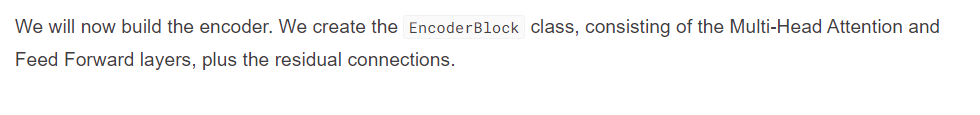

 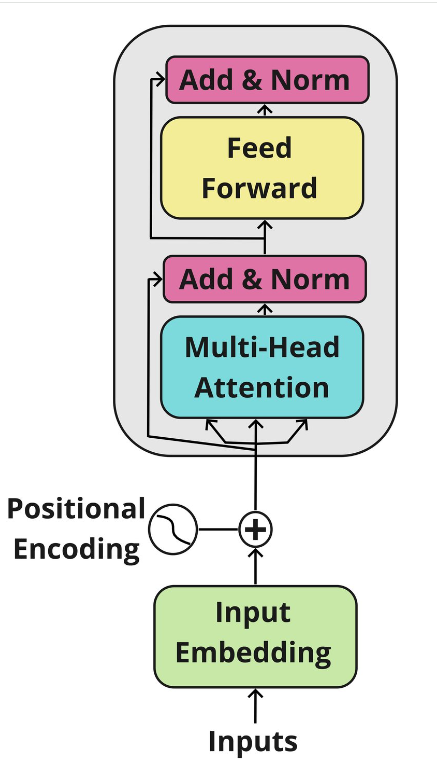



<pre>
original x
     |
   norm()
     |
normalized x (this becomes lambda’s x)
     |
lambda x: attention(x,x,x,mask)
     |
 self-attention output
     |
original x + dropout(output)   ← skip connection
</pre>

In [11]:

class EncoderBlock(nn.Module):

    # This block takes in the MultiHeadAttentionBlock and FeedForwardBlock, as well as the dropout rate for the residual connections
    def __init__(self, self_attention_block: MultiheadAttentionBlock, feed_forward_block:FeedForwardBlock, dropout:float) -> None:
      super().__init__()
      # Storing the self-attention block and feed-forward block
      self.self_attention_block = self_attention_block
      self.feed_forward_block = feed_forward_block
      self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)]) # 2 Residual Connections with dropout

    def forward(self, x, src_mask):
      # Applying the first residual connection with the self-attention block
      x = self.residual_connections[0](x, lambda x:  self.self_attention_block(x, x, x, src_mask))# Three 'x's corresponding to query, key, and value inputs plus source mask

      # Applying the second residual connection with the feed-forward block
      x = self.residual_connections[1](x, self.feed_forward_block)
      return x # Output tensor after applying self-attention and feed-forward layers with residual connections.



In [12]:
# Building Encoder
# An Encoder can have several Encoder Blocks

class Encoder(nn.Module):
  # The Encoder takes in instances of 'EncoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
      super().__init__()
      self.layers = layers # storing the EncoderBlocks
      self.norm = LayerNormalization()  # Layer for the normalization of the output of the encoder layers


    def forward(self, x, mask):
      # Iterating over each EncoderBlock stored in self.layers
      for layer in self.layers:
        x = layer(x, mask) # Applying each EncoderBlock with the input tensor 'x'
      return self.norm(x) # Normalizing output


# Decoder

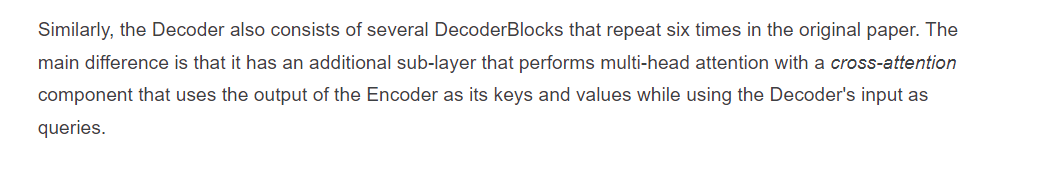

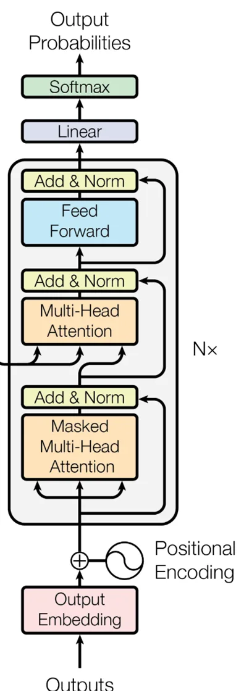

In [13]:

# Building Decoder Block
class DecoderBlock(nn.Module):

    # The DecoderBlock takes in two MultiHeadAttentionBlock. One is self-attention, while the other is cross-attention.
    # It also takes in the feed-forward block and the dropout rate
    def __init__(self, self_attention_block: MultiheadAttentionBlock ,cross_attention_block: MultiheadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block= self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)]) # List of three Residual Connections with dropout rate

    def forward( self, x, encoder_output, src_mask, tgt_mask):
       # Self-Attention block with query, key, and value plus the target language mask
       x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))

       # The Cross-Attention block using two 'encoder_ouput's for key and value plus the source language mask. It also takes in 'x' for Decoder queries
       x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))

       # Feed-forward block with residual connections
       x = self.residual_connection[2](x, self.feed_forward_block)
       return x


In [14]:
# Building Decoder
# A Decoder can have several Decoder Blocks
class Decoder(nn.Module):

    # The Decoder takes in instances of 'DecoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
      super.__init__()

      # Storing the DecoderBlock's
      self.layers = layers
      self.norm = LayerNormalization() # LAyer to normalize the output

    def forward(self, x, encoder_output, src_mask, tgt_mask):
      # Iterating over each DecoderBlock stored in self.layers
      for layer in self.layers:
        # Applies each DecoderBlock to the input 'x' plus the encoder output and source and target masks
            x = layer(x, encoder_output, src_mask, tgt_mask)
      return self.norm(x) # Returns normalized output


# Projection layer

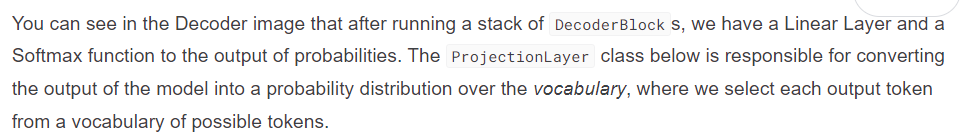

<pre>
| Step                  | What happens?                   | Output size |
| --------------------- | ------------------------------- | ----------- |
| **Linear Layer**      | Maps hidden state → logits      | vocab_size  |
| **Softmax**           | Converts logits → probabilities | vocab_size  |
| **Argmax / sampling** | Picks next word                 | 1 token     |

</pre>


In [15]:
# Buiding Linear Layer
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None: # Model dimension and the size of the output vocabulary
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
      return torch.log_softmax(self.proj(x), dim = -1) # Applying the log Softmax function to the output


# Building the Transformer

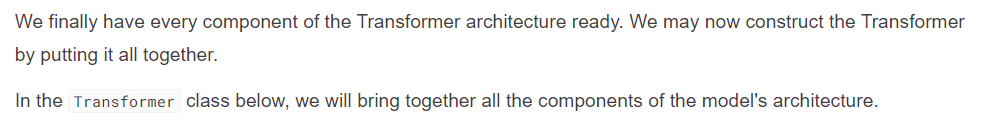

In [16]:
# Creating the Transformer Architecture
class Transformer(nn.Module):

    # This takes in the encoder and decoder, as well the embeddings for the source and target language.
    # It also takes in the Positional Encoding for the source and target language, as well as the projection layer
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddingsLayer, tgt_embed: InputEmbeddingsLayer, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    # Encoder
    def encode(self, src, src_mask):
        src = self.src_embed(src) # Applying source embeddings to the input source language
        src = self.src_pos(src) # Applying source positional encoding to the source embeddings
        return self.encoder(src, src_mask) # Returning the source embeddings plus a source mask to prevent attention to certain elements

    # Decoder
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt) # Applying target embeddings to the input target language (tgt)
        tgt = self.tgt_pos(tgt) # Applying target positional encoding to the target embeddings

        # Returning the target embeddings, the output of the encoder, and both source and target masks
        # The target mask ensures that the model won't 'see' future elements of the sequence
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    # Applying Projection Layer with the Softmax function to the Decoder output
    def projet(self, x):
      return self.projection_layer(x)



# Building And Initializig the Transformer

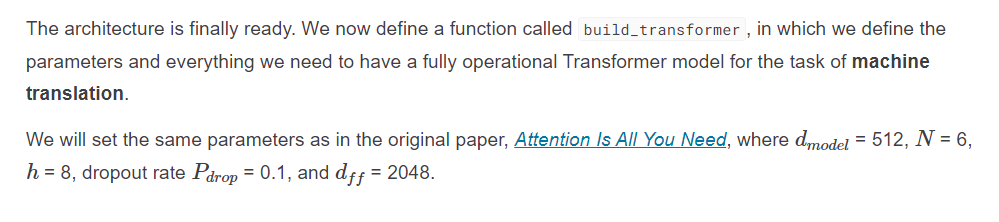

<pre>
[text]
   ↓
[tokenizer]
   ↓
[token IDs]
   ↓
[embeddings]
   ↓
[transformer decoder]
   ↓
[linear layer → logits (size = vocab_size)]
   ↓
[softmax → probabilities (size = vocab_size)]
   ↓
[argmax → token ID]
   ↓
[tokenizer → word]

</pre>


In [17]:

# Building & Initializing Transformer

# Definin function and its parameter, including model dimension, number of encoder and decoder stacks, heads, etc.
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:

  #Creating Embedding layers
  src_embed = InputEmbeddingsLayer(d_model, src_vocab_size)
  tgt_embed = InputEmbeddingsLayer(d_model, tgt_vocab_size)

  # Creating Positional Encoding layers
  src_pos = PositionalEncoding(d_model, src_seq_len, dropout) # Positional encoding for the source language embeddings
  tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout) # Positional encoding for the target language embeddings

  # Creating EncoderBlocks
  encoder_blocks = [] # Initial list of empty EncoderBlocks
  for _ in range(N):# Iterating 'N' times to create 'N' EncoderBlocks (N = 6)
     encoder_self_attention_block = MultiheadAttentionBlock(d_model, h, dropout)
     feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)

     # Combine layers into an EncoderBlock
     encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
     encoder_blocks.append(encoder_block) # Appending EncoderBlock to the list of EncoderBlocks

  # Creating DecoderBlocks
  decoder_blocks = [] # Initial list of empty DecoderBlocks
  for _ in range(N): # Iterating 'N' times to create 'N' DecoderBlocks (N = 6)
        decoder_self_attention_block = MultiheadAttentionBlock(d_model, h, dropout) # Self-Attention
        decoder_cross_attention_block = MultiheadAttentionBlock(d_model, h, dropout) # Cross-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combining layers into a DecoderBlock
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block) # Appending DecoderBlock to the list of DecoderBlocks

        # Creating the Encoder and Decoder by using the EncoderBlocks and DecoderBlocks lists
        encoder = Encoder(nn.ModuleList(encoder_blocks))
        decoder = Decoder(nn.ModuleList(decoder_blocks))

        # Creating projection layer
        projection_layer = ProjectionLayer(d_model, tgt_vocab_size) # Map the output of Decoder to the Target Vocabulary Space

        # Creating the transformer by combining everything above

        transformer = Transformer(encoder, decoder, src_embed, tgt_embed,src_pos, tgt_pos, projection_layer)

        # Initialize the parameters
        for p in transformer.parameters():
          if p.dim() > 1:
            nn.init.xavier_uniform_(p)
  return transformer # Assembled and initialized Transformer. Ready to be trained and validated!

<p style="color:black;">The model is now ready to be trained!</p>

# Tokenization